# Trial Summary 

Data preparation:
- Filter genes with less than 10 non-zero expressions spots
- Apply log transformation on the expressions

Model:
- Nueral Matrix Factorization

Results:
- Train RMSE: 4.06
- Valid RMSE: 6.38
- Test RMSE: 6.50

# Imports

In [1]:
from os import path, listdir
from copy import deepcopy
import stlearn as st
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import pickle
import torch.optim as optim
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from scanpy_stlearn_loaders import StlearnLoader
import trainer_nmf as trainer
import data_nmf as get_data
from data_nmf import get_expressions
from models import get_model
import tester_nmf as tester
from loss import *
from results_analysis import *

In [2]:
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Load Data 

In [3]:
min_counts = 500
min_cells = 177
apply_log = True
batch_size = 128

In [4]:
dl_train, dl_valid, dl_test, _ = get_data.main(
    min_counts=min_counts,
    min_cells=min_cells,
    apply_log=apply_log, 
    batch_size=batch_size, 
    device=device
)

Finish loading the data


# Modelling

## Set HyperParameters

In [5]:
model_name = 'NMF'
max_epochs = 150
early_stopping = 10
model_params = {
    'learning_rate': 0.1,
    'optimizer': "SGD",
    'latent_dim': 40,
    'batch_size': batch_size
}
trial_name = 'LogTransform'

## Build Model 

In [6]:
model = get_model(model_name, model_params, dl_train)
optimizer = getattr(optim, model_params['optimizer'])(model.parameters(), lr=model_params['learning_rate'])
criterion = RMSELoss()

## Train Model 

In [7]:
model, valid_loss = trainer.train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    max_epochs=max_epochs,
    early_stopping=early_stopping,
    dl_train=dl_train,
    dl_valid=dl_valid, 
    dl_test=dl_test,
    device=device,
    trial_name=trial_name
)

2022-10-01 13:45:30.778247: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-01 13:45:30.992397: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-01 13:45:30.992439: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-01 13:45:31.049765: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-01 13:45:32.412232: W tensorflow/stream_executor/platform/de

Training Results - Epoch[1] Avg loss: 7.54
Validation Results - Epoch[1] Avg loss: 13.88
Training Results - Epoch[2] Avg loss: 6.71
Validation Results - Epoch[2] Avg loss: 13.35
Training Results - Epoch[3] Avg loss: 6.12
Validation Results - Epoch[3] Avg loss: 12.31
Training Results - Epoch[4] Avg loss: 5.28
Validation Results - Epoch[4] Avg loss: 10.12
Training Results - Epoch[5] Avg loss: 5.05
Validation Results - Epoch[5] Avg loss: 8.99
Training Results - Epoch[6] Avg loss: 4.95
Validation Results - Epoch[6] Avg loss: 8.50
Training Results - Epoch[8] Avg loss: 4.75
Validation Results - Epoch[8] Avg loss: 7.59
Training Results - Epoch[9] Avg loss: 4.66
Validation Results - Epoch[9] Avg loss: 7.27
Training Results - Epoch[10] Avg loss: 4.57
Validation Results - Epoch[10] Avg loss: 6.90
Training Results - Epoch[11] Avg loss: 4.49
Validation Results - Epoch[11] Avg loss: 6.59
Training Results - Epoch[12] Avg loss: 4.45
Validation Results - Epoch[12] Avg loss: 6.44
Training Results - Epo

2022-10-01 16:31:11,217 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Results - Epoch[29] Avg loss: 6.38
Test Results - Avg loss: 6.50


## Test 

In [24]:
_, df_test_preds = tester.test(
    model=model,
    criterion=criterion,
    dl_test=dl_test,
    device=device
)

# Results Analysis 

In [25]:
y_col = 'y'
y_pred_col = 'y_pred'

df_test_preds['error'] = df_test_preds[y_col] - df_test_preds[y_pred_col]
df_test_preds.head()

,gene,spot,y,y_pred,error
0,4215,701,2.0,0.008749,1.991251
1,4800,114,2.0,1.876993,0.123007
2,5678,868,3.0,0.495094,2.504906
3,4909,425,2.0,0.618211,1.381789
4,1901,143,1.0,-0.016912,1.016912


## Errors Distribution 

## Spots Errors Distribution 

In [26]:
spots_error_distribution(df_test_preds)

count    1185.000000
mean        1.878094
std         0.715028
min         0.711817
25%         1.396997
50%         1.696018
75%         2.145538
max         5.476667
Name: error, dtype: float64


## Genes Errors Distribution 

In [27]:
genes_error_distribution(df_test_preds)

count    6279.000000
mean        1.603435
std         6.231120
min         0.542520
25%         0.959343
50%         1.077159
75%         1.293585
max       350.204399
Name: error, dtype: float64


## Errors Heat Map 

(1185, 6279)


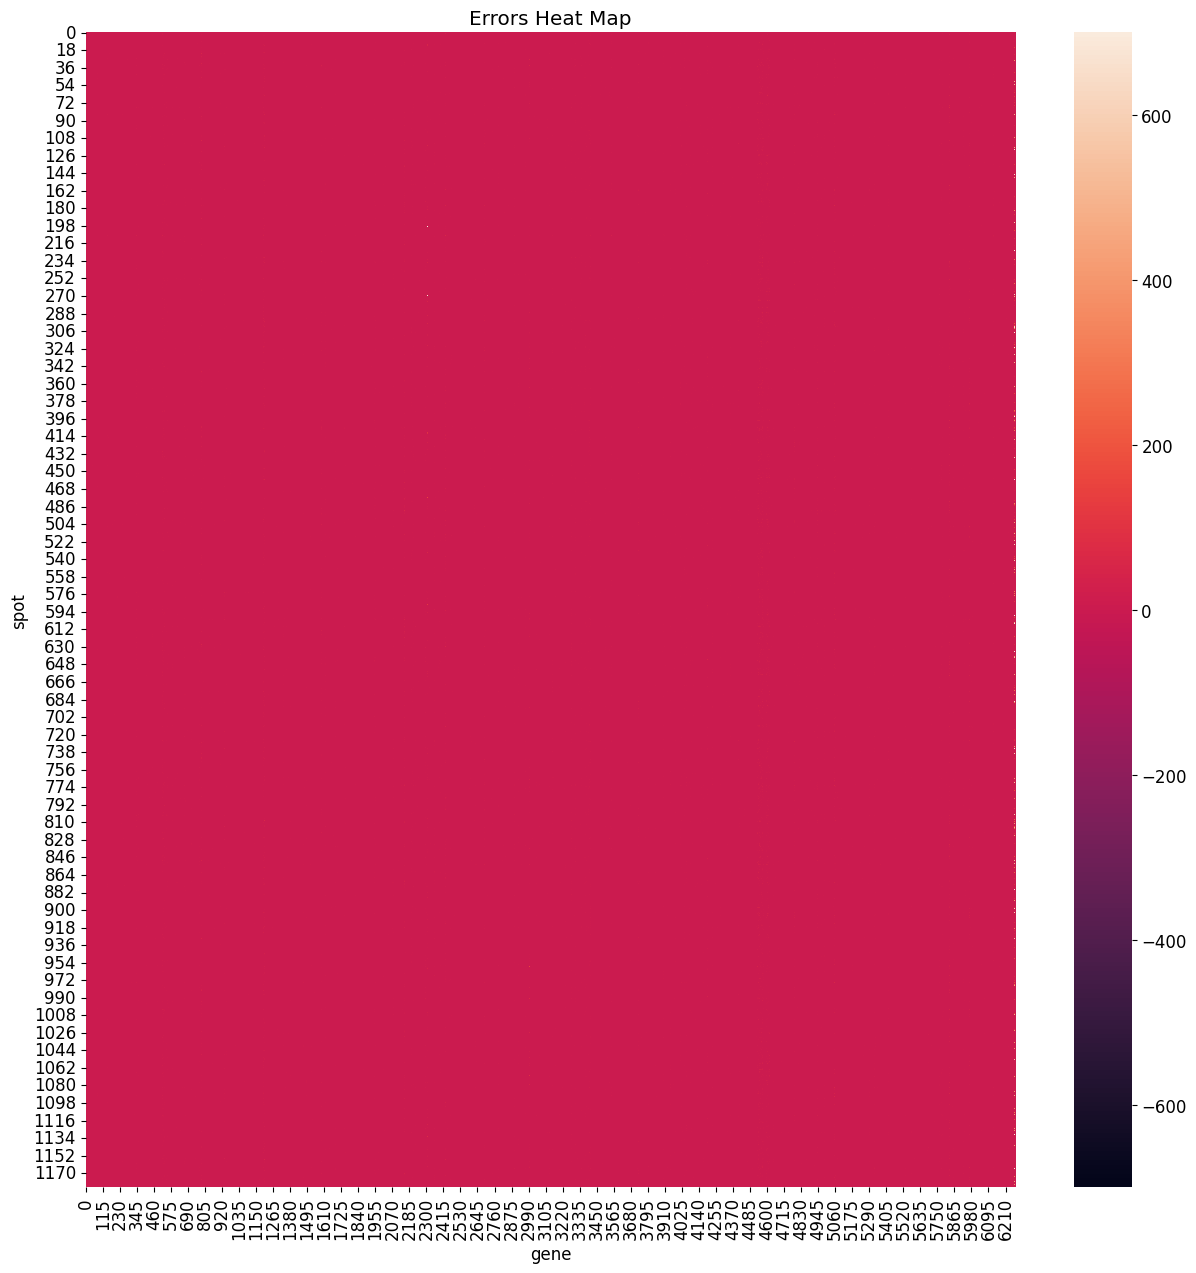

In [28]:
error_heat_map(df_test_preds, vmin=-700, vmax=700)

# PCA + KMeans Clustering 

In [37]:
_, obj, _, _ = get_expressions(min_counts=min_counts, min_cells=min_cells, apply_log=apply_log)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# spots: 1185 | # genes: 32285
New shape after filtering: (1185, 6279)
Log transformation step is finished in adata.X
Data shape: (7440615, 3)
Number of genes: 6279
Number of spots: 1185


In [38]:
# Load Ordinal Encoders
with open(path.join('/', 'data', 'NMF', 'genes_encoder.pkl'), 'rb') as f:
    oe_genes = pickle.load(f)
with open(path.join('/', 'data', 'NMF', 'spots_encoder.pkl'), 'rb') as f:
    oe_spots = pickle.load(f)

dl_train_nmf = torch.load(path.join('/', 'data', 'NMF', 'dl_train.pth'))
nmf_train_genes, nmf_train_spots, nmf_train_expressions = dl_train_nmf.dataset.get_all_data()
df_nmf_train_tmp = pd.DataFrame({'gene': nmf_train_genes.to('cpu'), 'spot': nmf_train_spots.to('cpu'), 'expression': nmf_train_expressions.to('cpu')})
df_nmf_train_tmp[['gene']] = oe_genes.inverse_transform(df_nmf_train_tmp[['gene']].values)
df_nmf_train_tmp[['spot']] = oe_spots.inverse_transform(df_nmf_train_tmp[['spot']].values)
df_nmf_train_matrix_tmp = df_nmf_train_tmp.pivot(index='spot', columns='gene', values='expression')

In [39]:
df_nmf_train = df_test_preds[['gene', 'spot', y_pred_col]].rename(columns={y_pred_col: 'expression'})
df_nmf_train[['gene']] = oe_genes.inverse_transform(df_nmf_train[['gene']].values)
df_nmf_train[['spot']] = oe_spots.inverse_transform(df_nmf_train[['spot']].values)
df_nmf_train_matrix = df_nmf_train.pivot(index='spot', columns='gene', values='expression')
df_nmf_train_matrix.fillna(df_nmf_train_matrix_tmp, inplace=True)
df_nmf_train_matrix.clip(lower=0, inplace=True)
display(df_nmf_train_matrix.head())
tmp_genes_locations = [obj.var.index.get_loc(key=gene_key) for gene_key in df_nmf_train_matrix.columns]
# Replace the values
obj.X[:, tmp_genes_locations] = df_nmf_train_matrix.values

gene,0610009B22Rik,0610009L18Rik,0610010K14Rik,0610012G03Rik,1110004F10Rik,1110008P14Rik,1110032A03Rik,1110038B12Rik,1110038F14Rik,1110051M20Rik,...,mt-Co1,mt-Co2,mt-Co3,mt-Cytb,mt-Nd1,mt-Nd2,mt-Nd3,mt-Nd4,mt-Nd4l,mt-Nd5
spot,,,,,,,,,,,,,,,,,,,,,
AAACAAGTATCTCCCA-1,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,...,62.000000,28.000000,13.16871,28.0,9.000000,0.928028,4.0,22.0,0.000000,0.0
AAACCGGGTAGGTACC-1,1.0,0.000000,0.140664,3.431838,3.0,3.851521,7.000000,1.765372,0.0,2.029407,...,1587.000000,962.000000,1292.00000,571.0,398.000000,318.000000,58.0,0.0,6.512482,31.0
AAACCGTTCGTCCAGG-1,0.0,0.925491,0.000000,6.000000,7.0,2.867362,0.892008,1.000000,0.0,8.000000,...,832.000000,449.790527,761.00000,339.0,0.000000,171.000000,42.0,278.0,3.000000,0.0
AAACGAGACGGTTGAT-1,1.0,0.000000,2.247161,0.000000,0.0,3.000000,1.000000,0.000000,3.0,4.000000,...,575.000000,0.000000,562.00000,0.0,178.000000,119.000000,25.0,175.0,3.000000,0.0
AAACTGCTGGCTCCAA-1,1.0,0.438514,2.000000,4.000000,0.0,0.000000,0.000000,0.000000,1.0,1.703661,...,359.900513,211.385254,691.00000,306.0,115.874252,0.000000,34.0,0.0,1.000000,27.0


/usr/local/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Normalization step is finished in adata.X
Log transformation step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Applying Kmeans clustering ...
Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]


<Figure size 640x480 with 0 Axes>

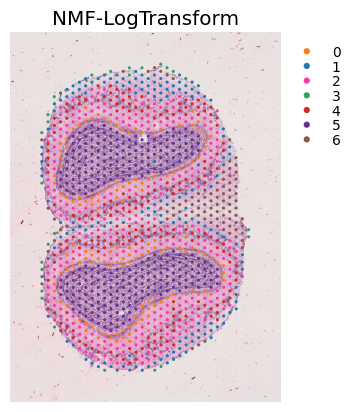

In [40]:
pca_kmeans_clustering(
    data_obj=obj, 
    title=f'NMF-{trial_name}'
)